In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Skip the downloading stuff, we don't want to bring down the website

In [2]:
import requests
from bs4 import BeautifulSoup
from itertools import product
from functools import lru_cache

sess = requests.session()
sess.headers.update({
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36"
})

@lru_cache(maxsize=2000)
def fetch(url):
    res = sess.get(url)
    res = BeautifulSoup(res.content, "html.parser")
    return res
    

In [3]:
from urllib.parse import urlparse

main = fetch("https://www.the-digital-picture.com/Reviews/ISO-12233-Sample-Crops.aspx")
available_lenses = [(o["value"], o.text) for o in main.find("select", {"name": "Lens"}).find_all("option") if o.text.startswith("Canon")]
available_lenses

[('950', 'Canon EF-S 10-18mm f/4.5-5.6 IS STM Lens'),
 ('271', 'Canon EF-S 10-22mm f/3.5-4.5 USM Lens'),
 ('967', 'Canon EF-M 11-22mm f/4-5.6 IS STM Lens'),
 ('977', 'Canon EF 11-24mm f/4L USM Lens'),
 ('1569', 'Canon RF 14-35mm F4 L IS USM Lens'),
 ('1624', 'Canon RF 15-30mm F4.5-6.3 IS STM Lens'),
 ('1414', 'Canon RF 15-35mm F2.8 L IS USM Lens'),
 ('1114', 'Canon EF-M 15-45mm f/3.5-6.3 IS STM Lens'),
 ('675', 'Canon EF-S 15-85mm f/3.5-5.6 IS USM Lens'),
 ('1073', 'Canon EF 16-35mm f/2.8L III USM Lens'),
 ('412', 'Canon EF 16-35mm f/2.8L II USM Lens'),
 ('114', 'Canon EF 16-35mm f/2.8L USM Lens'),
 ('949', 'Canon EF 16-35mm f/4L IS USM Lens'),
 ('100', 'Canon EF 17-40mm f/4L USM Lens'),
 ('398', 'Canon EF-S 17-55mm f/2.8 IS USM Lens'),
 ('251', 'Canon EF-S 17-85mm f/4-5.6 IS USM Lens'),
 ('1621', 'Canon RF-S 18-45mm F4.5-6.3 IS STM Lens'),
 ('836', 'Canon EF-S 18-55mm f/3.5-5.6 IS STM Lens'),
 ('763', 'Canon EF-S 18-55mm f/3.5-5.6 IS II Lens'),
 ('455', 'Canon EF-S 18-55mm f/3.5-5.6 I

In [4]:
def download(url):
    res = sess.get(url)
    return res.content

In [5]:
import os
from tqdm import tqdm
import threading

img_path = "lenses"

all_images = []
_lock = threading.RLock()

def clean(s):
    return s.replace("/", "").replace(" ", "").strip().replace("LensImageQuality", "")

def add_from(lens, aperture, focal, camera):
    u = f"https://www.the-digital-picture.com/Reviews/ISO-12233-Sample-Crops.aspx?Lens={lens}&FLI={focal[0]}&API={aperture[0]}&Camera={camera[0]}"
    res = fetch(u)
    title = res.find("h1").get_text().strip()
    images = [i for i in res.find("div", {"id": "Main"}).find_all("img") if i.get("id", None) is not None]
    
    ap_name = clean(aperture[1])
    f_name = clean(focal[1])
    c_title = clean(title)
    cam_name = clean(camera[1])
    
    img_p = f"{img_path}/{lens}-{c_title}/{cam_name}/{f_name}/{ap_name}"
    
    with _lock:
        os.makedirs(img_p, exist_ok=True)
        
    for img in images:
        src = img["src"]
        ix = src.split("/")[-2]
        img_pp = f"{img_p}/{ix}.jpg"
        with _lock:
            all_images.append({
                "lens": lens,
                "title": c_title,
                "aperture": ap_name,
                "focal_length": f_name,
                "img_location": img_pp,
                "img_url": src,
                "crop_name": ix,
                "camera": cam_name,
            })
        
        with _lock:
            if os.path.exists(img_pp):
                continue
                
        b_data = download(src)
        if len(b_data) < 1000:
            print("!!!Check", src)
            
        with _lock:
            with open(img_pp, "wb") as f:
                f.write(b_data)

from concurrent.futures import ThreadPoolExecutor, as_completed


def one_lens(args):
    lens_id, name = args
    res = fetch(f"https://www.the-digital-picture.com/Reviews/ISO-12233-Sample-Crops.aspx?Lens={lens_id}&FLI=0&API=0&Camera=0")

    available_fli = [(o["value"], o.text) for o in res.find("select", {"name": "FLI"}).find_all("option")]
    available_cam = [(o["value"], o.text) for o in res.find("select", {"name": "Camera"}).find_all("option")]
    for cam in available_cam:
        with _lock:
            print(lens_id, name, cam)
        for focal in available_fli:
            res3 = fetch(f"https://www.the-digital-picture.com/Reviews/ISO-12233-Sample-Crops.aspx?Lens={lens_id}&FLI={focal[0]}&API=0&Camera={cam[0]}")
            available_api = [(o["value"], o.text) for o in res3.find("select", {"name": "API"}).find_all("option")]

            for aperture in available_api:
                add_from(lens_id, aperture, focal, cam)
                
with ThreadPoolExecutor(10) as tpe:
    futures = []
    for l in available_lenses:
        futures.append(tpe.submit(one_lens, l))
    
    for res in tqdm(as_completed(futures), total=len(futures)):
        pass

  0%|                                                                                                                                                                                                               | 0/149 [00:00<?, ?it/s]

950 Canon EF-S 10-18mm f/4.5-5.6 IS STM Lens ('963', 'Canon EOS 7D Mark II')
675 Canon EF-S 15-85mm f/3.5-5.6 IS USM Lens ('963', 'Canon EOS 7D Mark II')
977 Canon EF 11-24mm f/4L USM Lens ('453', 'Canon EOS-1Ds Mark III')
1114 Canon EF-M 15-45mm f/3.5-6.3 IS STM Lens ('812', 'Canon EOS M')
271 Canon EF-S 10-22mm f/3.5-4.5 USM Lens ('963', 'Canon EOS 7D Mark II')
967 Canon EF-M 11-22mm f/4-5.6 IS STM Lens ('812', 'Canon EOS M')
1073 Canon EF 16-35mm f/2.8L III USM Lens ('453', 'Canon EOS-1Ds Mark III')
1414 Canon RF 15-35mm F2.8 L IS USM Lens ('1508', 'Canon EOS R5')
1624 Canon RF 15-30mm F4.5-6.3 IS STM Lens ('1508', 'Canon EOS R5')
1569 Canon RF 14-35mm F4 L IS USM Lens ('1508', 'Canon EOS R5')
977 Canon EF 11-24mm f/4L USM Lens ('979', 'Canon EOS 5Ds R')
1414 Canon RF 15-35mm F2.8 L IS USM Lens ('1221', 'Canon EOS R')


  1%|█▎                                                                                                                                                                                                     | 1/149 [00:20<49:47, 20.19s/it]

412 Canon EF 16-35mm f/2.8L II USM Lens ('453', 'Canon EOS-1Ds Mark III')


  1%|██▋                                                                                                                                                                                                    | 2/149 [00:26<30:05, 12.28s/it]

114 Canon EF 16-35mm f/2.8L USM Lens ('9', 'Canon EOS-1Ds Mark II')
977 Canon EF 11-24mm f/4L USM Lens ('963', 'Canon EOS 7D Mark II')


  2%|████                                                                                                                                                                                                   | 3/149 [00:38<28:45, 11.82s/it]

949 Canon EF 16-35mm f/4L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
950 Canon EF-S 10-18mm f/4.5-5.6 IS STM Lens ('736', 'Canon EOS 60D')


  3%|█████▎                                                                                                                                                                                                 | 4/149 [00:45<23:59,  9.93s/it]

100 Canon EF 17-40mm f/4L USM Lens ('453', 'Canon EOS-1Ds Mark III')
271 Canon EF-S 10-22mm f/3.5-4.5 USM Lens ('736', 'Canon EOS 60D')
977 Canon EF 11-24mm f/4L USM Lens ('1221', 'Canon EOS R')
675 Canon EF-S 15-85mm f/3.5-5.6 IS USM Lens ('736', 'Canon EOS 60D')
1073 Canon EF 16-35mm f/2.8L III USM Lens ('979', 'Canon EOS 5Ds R')
412 Canon EF 16-35mm f/2.8L II USM Lens ('9', 'Canon EOS-1Ds Mark II')


  3%|██████▋                                                                                                                                                                                                | 5/149 [01:27<51:41, 21.54s/it]

398 Canon EF-S 17-55mm f/2.8 IS USM Lens ('963', 'Canon EOS 7D Mark II')


  4%|████████                                                                                                                                                                                               | 6/149 [01:30<36:01, 15.12s/it]

251 Canon EF-S 17-85mm f/4-5.6 IS USM Lens ('736', 'Canon EOS 60D')


  5%|█████████▎                                                                                                                                                                                             | 7/149 [01:31<25:20, 10.71s/it]

949 Canon EF 16-35mm f/4L IS USM Lens ('979', 'Canon EOS 5Ds R')
1621 Canon RF-S 18-45mm F4.5-6.3 IS STM Lens ('1619', 'Canon EOS R7')
271 Canon EF-S 10-22mm f/3.5-4.5 USM Lens ('474', 'Canon EOS 50D')
675 Canon EF-S 15-85mm f/3.5-5.6 IS USM Lens ('474', 'Canon EOS 50D')
100 Canon EF 17-40mm f/4L USM Lens ('979', 'Canon EOS 5Ds R')


  5%|██████████▋                                                                                                                                                                                            | 8/149 [02:13<48:13, 20.52s/it]

836 Canon EF-S 18-55mm f/3.5-5.6 IS STM Lens ('736', 'Canon EOS 60D')
412 Canon EF 16-35mm f/2.8L II USM Lens ('979', 'Canon EOS 5Ds R')
251 Canon EF-S 17-85mm f/4-5.6 IS USM Lens ('474', 'Canon EOS 50D')
949 Canon EF 16-35mm f/4L IS USM Lens ('963', 'Canon EOS 7D Mark II')
398 Canon EF-S 17-55mm f/2.8 IS USM Lens ('736', 'Canon EOS 60D')
1073 Canon EF 16-35mm f/2.8L III USM Lens ('963', 'Canon EOS 7D Mark II')


  6%|████████████                                                                                                                                                                                           | 9/149 [02:32<46:41, 20.01s/it]

763 Canon EF-S 18-55mm f/3.5-5.6 IS II Lens ('963', 'Canon EOS 7D Mark II')
!!!Check https://media.the-digital-picture.com/Images/Lens-Tests/ISO-12233/Canon-EF-S-15-85mm-f-3.5-5.6-IS-USM-Lens/Crop1/2009-10-19_13-34-43.jpg


  7%|█████████████▎                                                                                                                                                                                        | 10/149 [02:53<47:09, 20.35s/it]

455 Canon EF-S 18-55mm f/3.5-5.6 IS Lens ('474', 'Canon EOS 50D')


  7%|██████████████▌                                                                                                                                                                                       | 11/149 [02:54<33:32, 14.58s/it]

410 Canon EF-S 18-55mm f/3.5-5.6 II Lens ('396', 'Canon EOS 30D')


  8%|███████████████▉                                                                                                                                                                                      | 12/149 [02:56<24:46, 10.85s/it]

813 Canon EF-M 18-55mm f/3.5-5.6 IS STM Lens ('812', 'Canon EOS M')
398 Canon EF-S 17-55mm f/2.8 IS USM Lens ('474', 'Canon EOS 50D')
763 Canon EF-S 18-55mm f/3.5-5.6 IS II Lens ('736', 'Canon EOS 60D')
100 Canon EF 17-40mm f/4L USM Lens ('963', 'Canon EOS 7D Mark II')
949 Canon EF 16-35mm f/4L IS USM Lens ('736', 'Canon EOS 60D')
251 Canon EF-S 17-85mm f/4-5.6 IS USM Lens ('396', 'Canon EOS 30D')
455 Canon EF-S 18-55mm f/3.5-5.6 IS Lens ('452', 'Canon EOS 40D')


  9%|█████████████████▎                                                                                                                                                                                    | 13/149 [03:37<45:11, 19.93s/it]

1112 Canon EF-S 18-55mm f/4-5.6 IS STM Lens ('963', 'Canon EOS 7D Mark II')
1073 Canon EF 16-35mm f/2.8L III USM Lens ('1221', 'Canon EOS R')


  9%|██████████████████▌                                                                                                                                                                                   | 14/149 [03:54<42:56, 19.08s/it]

1045 Canon EF-S 18-135mm f/3.5-5.6 IS USM Lens ('963', 'Canon EOS 7D Mark II')
763 Canon EF-S 18-55mm f/3.5-5.6 IS II Lens ('474', 'Canon EOS 50D')


 10%|███████████████████▉                                                                                                                                                                                  | 15/149 [04:03<35:48, 16.03s/it]

809 Canon EF-S 18-135mm f/3.5-5.6 IS STM Lens ('963', 'Canon EOS 7D Mark II')
412 Canon EF 16-35mm f/2.8L II USM Lens ('963', 'Canon EOS 7D Mark II')


 11%|██████████████████████▌                                                                                                                                                                               | 17/149 [04:20<25:00, 11.37s/it]

678 Canon EF-S 18-135mm f/3.5-5.6 IS Lens ('736', 'Canon EOS 60D')
1622 Canon RF-S 18-150mm F3.5-6.3 IS STM Lens ('1619', 'Canon EOS R7')


 12%|███████████████████████▉                                                                                                                                                                              | 18/149 [04:24<20:05,  9.20s/it]

1134 Canon EF-M 18-150mm f/3.5-6.3 IS STM Lens ('812', 'Canon EOS M')


 13%|█████████████████████████▏                                                                                                                                                                            | 19/149 [04:25<14:22,  6.63s/it]

476 Canon EF-S 18-200mm f/3.5-5.6 IS Lens ('963', 'Canon EOS 7D Mark II')
100 Canon EF 17-40mm f/4L USM Lens ('736', 'Canon EOS 60D')


 13%|██████████████████████████▌                                                                                                                                                                           | 20/149 [04:45<22:50, 10.63s/it]

1642 Canon RF 24-50mm F4.5-6.3 IS STM Lens ('1508', 'Canon EOS R5')


 14%|███████████████████████████▉                                                                                                                                                                          | 21/149 [04:49<18:40,  8.75s/it]

1415 Canon RF 24-70mm F2.8 L IS USM Lens ('1508', 'Canon EOS R5')
809 Canon EF-S 18-135mm f/3.5-5.6 IS STM Lens ('736', 'Canon EOS 60D')


 15%|█████████████████████████████▏                                                                                                                                                                        | 22/149 [05:02<21:19, 10.08s/it]

1415 Canon RF 24-70mm F2.8 L IS USM Lens ('1221', 'Canon EOS R')
787 Canon EF 24-70mm f/2.8L II USM Lens ('453', 'Canon EOS-1Ds Mark III')


 15%|██████████████████████████████▌                                                                                                                                                                       | 23/149 [05:17<23:58, 11.42s/it]

101 Canon EF 24-70mm f/2.8L USM Lens ('453', 'Canon EOS-1Ds Mark III')
678 Canon EF-S 18-135mm f/3.5-5.6 IS Lens ('474', 'Canon EOS 50D')
412 Canon EF 16-35mm f/2.8L II USM Lens ('736', 'Canon EOS 60D')
100 Canon EF 17-40mm f/4L USM Lens ('474', 'Canon EOS 50D')


 16%|███████████████████████████████▉                                                                                                                                                                      | 24/149 [05:34<27:00, 12.97s/it]

823 Canon EF 24-70mm f/4L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
476 Canon EF-S 18-200mm f/3.5-5.6 IS Lens ('736', 'Canon EOS 60D')


 17%|█████████████████████████████████▏                                                                                                                                                                    | 25/149 [05:46<26:44, 12.94s/it]

119 Canon EF 24-85mm f/3.5-4.5 USM Lens ('453', 'Canon EOS-1Ds Mark III')


 17%|██████████████████████████████████▌                                                                                                                                                                   | 26/149 [05:58<25:28, 12.43s/it]

1222 Canon RF 24-105mm F4 L IS USM Lens ('1508', 'Canon EOS R5')
787 Canon EF 24-70mm f/2.8L II USM Lens ('979', 'Canon EOS 5Ds R')
823 Canon EF 24-70mm f/4L IS USM Lens ('979', 'Canon EOS 5Ds R')
1222 Canon RF 24-105mm F4 L IS USM Lens ('1221', 'Canon EOS R')


 18%|███████████████████████████████████▉                                                                                                                                                                  | 27/149 [06:20<31:21, 15.42s/it]

1072 Canon EF 24-105mm f/4L IS II USM Lens ('453', 'Canon EOS-1Ds Mark III')


 19%|█████████████████████████████████████▏                                                                                                                                                                | 28/149 [06:22<22:45, 11.28s/it]

355 Canon EF 24-105mm f/4L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')


 19%|██████████████████████████████████████▌                                                                                                                                                               | 29/149 [06:32<21:59, 11.00s/it]

961 Canon EF 24-105mm f/3.5-5.6 IS STM Lens ('453', 'Canon EOS-1Ds Mark III')
119 Canon EF 24-85mm f/3.5-4.5 USM Lens ('9', 'Canon EOS-1Ds Mark II')


 20%|███████████████████████████████████████▊                                                                                                                                                              | 30/149 [06:36<17:29,  8.82s/it]

1504 Canon RF 24-105mm F4-7.1 IS STM Lens ('1508', 'Canon EOS R5')


 21%|█████████████████████████████████████████▏                                                                                                                                                            | 31/149 [06:40<14:39,  7.46s/it]

1416 Canon RF 24-240mm F4-6.3 IS USM Lens ('1508', 'Canon EOS R5')
476 Canon EF-S 18-200mm f/3.5-5.6 IS Lens ('474', 'Canon EOS 50D')
1504 Canon RF 24-105mm F4-7.1 IS STM Lens ('1221', 'Canon EOS R')
1416 Canon RF 24-240mm F4-6.3 IS USM Lens ('1221', 'Canon EOS R')
355 Canon EF 24-105mm f/4L IS USM Lens ('979', 'Canon EOS 5Ds R')
823 Canon EF 24-70mm f/4L IS USM Lens ('963', 'Canon EOS 7D Mark II')
1072 Canon EF 24-105mm f/4L IS II USM Lens ('979', 'Canon EOS 5Ds R')


 21%|██████████████████████████████████████████▌                                                                                                                                                           | 32/149 [07:31<40:02, 20.54s/it]

1223 Canon RF 28-70mm F2 L USM Lens ('1508', 'Canon EOS R5')
961 Canon EF 24-105mm f/3.5-5.6 IS STM Lens ('979', 'Canon EOS 5Ds R')
787 Canon EF 24-70mm f/2.8L II USM Lens ('963', 'Canon EOS 7D Mark II')
1223 Canon RF 28-70mm F2 L USM Lens ('1221', 'Canon EOS R')


 22%|███████████████████████████████████████████▊                                                                                                                                                          | 33/149 [07:57<42:56, 22.21s/it]

102 Canon EF 28-70mm f/2.8L USM Lens ('453', 'Canon EOS-1Ds Mark III')


 23%|█████████████████████████████████████████████▏                                                                                                                                                        | 34/149 [08:07<35:37, 18.58s/it]

302 Canon EF 28-105mm f/3.5-4.5 II USM Lens ('453', 'Canon EOS-1Ds Mark III')


 23%|██████████████████████████████████████████████▌                                                                                                                                                       | 35/149 [08:12<27:19, 14.38s/it]

116 Canon EF 28-135mm f/3.5-5.6 IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
823 Canon EF 24-70mm f/4L IS USM Lens ('736', 'Canon EOS 60D')


 24%|███████████████████████████████████████████████▊                                                                                                                                                      | 36/149 [08:21<23:59, 12.74s/it]

286 Canon EF 28-200mm f/3.5-5.6 USM Lens ('453', 'Canon EOS-1Ds Mark III')
787 Canon EF 24-70mm f/2.8L II USM Lens ('736', 'Canon EOS 60D')


 25%|█████████████████████████████████████████████████▏                                                                                                                                                    | 37/149 [08:50<33:05, 17.73s/it]

295 Canon EF 28-300mm f/3.5-5.6L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')


 26%|██████████████████████████████████████████████████▍                                                                                                                                                   | 38/149 [08:51<23:26, 12.67s/it]

968 Canon EF-M 55-200mm f/4.5-6.3 IS STM Lens ('812', 'Canon EOS M')


 26%|███████████████████████████████████████████████████▊                                                                                                                                                  | 39/149 [09:04<23:19, 12.72s/it]

1643 Canon RF-S 55-210mm F5-7.1 IS STM Lens ('1619', 'Canon EOS R7')
355 Canon EF 24-105mm f/4L IS USM Lens ('963', 'Canon EOS 7D Mark II')
1072 Canon EF 24-105mm f/4L IS II USM Lens ('963', 'Canon EOS 7D Mark II')
116 Canon EF 28-135mm f/3.5-5.6 IS USM Lens ('9', 'Canon EOS-1Ds Mark II')


 27%|█████████████████████████████████████████████████████▏                                                                                                                                                | 40/149 [09:28<29:22, 16.17s/it]

856 Canon EF-S 55-250mm f/4-5.6 IS STM Lens ('963', 'Canon EOS 7D Mark II')
961 Canon EF 24-105mm f/3.5-5.6 IS STM Lens ('963', 'Canon EOS 7D Mark II')


 28%|██████████████████████████████████████████████████████▍                                                                                                                                               | 41/149 [09:32<22:20, 12.41s/it]

777 Canon EF-S 55-250mm f/4-5.6 IS II Lens ('736', 'Canon EOS 60D')


 28%|███████████████████████████████████████████████████████▊                                                                                                                                              | 42/149 [09:47<23:49, 13.36s/it]

456 Canon EF-S 55-250mm f/4-5.6 IS Lens ('474', 'Canon EOS 50D')
787 Canon EF 24-70mm f/2.8L II USM Lens ('1221', 'Canon EOS R')
355 Canon EF 24-105mm f/4L IS USM Lens ('736', 'Canon EOS 60D')
777 Canon EF-S 55-250mm f/4-5.6 IS II Lens ('474', 'Canon EOS 50D')
856 Canon EF-S 55-250mm f/4-5.6 IS STM Lens ('736', 'Canon EOS 60D')


 29%|█████████████████████████████████████████████████████████▏                                                                                                                                            | 43/149 [10:27<37:24, 21.18s/it]

1417 Canon RF 70-200mm F2.8 L IS USM Lens ('1553', 'Canon EOS R3')
295 Canon EF 28-300mm f/3.5-5.6L IS USM Lens ('979', 'Canon EOS 5Ds R')
961 Canon EF 24-105mm f/3.5-5.6 IS STM Lens ('736', 'Canon EOS 60D')
1072 Canon EF 24-105mm f/4L IS II USM Lens ('1221', 'Canon EOS R')
116 Canon EF 28-135mm f/3.5-5.6 IS USM Lens ('979', 'Canon EOS 5Ds R')
456 Canon EF-S 55-250mm f/4-5.6 IS Lens ('452', 'Canon EOS 40D')
!!!Check https://media.the-digital-picture.com/Images/Lens-Tests/ISO-12233/Canon-RF-70-200mm-F2.8-L-IS-USM-Lens/Crop5/2021-11-04_08-08-57.jpg
1417 Canon RF 70-200mm F2.8 L IS USM Lens ('1508', 'Canon EOS R5')


 30%|██████████████████████████████████████████████████████████▍                                                                                                                                           | 44/149 [11:14<51:00, 29.15s/it]

1197 Canon EF 70-200mm f/2.8L IS III USM Lens ('979', 'Canon EOS 5Ds R')
1417 Canon RF 70-200mm F2.8 L IS USM Lens ('1221', 'Canon EOS R')


 30%|███████████████████████████████████████████████████████████▊                                                                                                                                          | 45/149 [11:16<35:59, 20.76s/it]

687 Canon EF 70-200mm f/2.8L IS II USM Lens ('453', 'Canon EOS-1Ds Mark III')


 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                        | 46/149 [11:19<26:50, 15.64s/it]

103 Canon EF 70-200mm f/2.8L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')


 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                       | 47/149 [11:39<28:52, 16.99s/it]

242 Canon EF 70-200mm f/2.8L USM Lens ('453', 'Canon EOS-1Ds Mark III')


 32%|███████████████████████████████████████████████████████████████▊                                                                                                                                      | 48/149 [11:41<20:53, 12.41s/it]

1529 Canon RF 70-200mm F4 L IS USM Lens ('1508', 'Canon EOS R5')


 33%|█████████████████████████████████████████████████████████████████                                                                                                                                     | 49/149 [11:52<19:42, 11.83s/it]

1198 Canon EF 70-200mm f/4L IS II USM Lens ('453', 'Canon EOS-1Ds Mark III')


 34%|██████████████████████████████████████████████████████████████████▍                                                                                                                                   | 50/149 [11:56<15:53,  9.63s/it]

404 Canon EF 70-200mm f/4L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
687 Canon EF 70-200mm f/2.8L IS II USM Lens ('979', 'Canon EOS 5Ds R')
116 Canon EF 28-135mm f/3.5-5.6 IS USM Lens ('963', 'Canon EOS 7D Mark II')
103 Canon EF 70-200mm f/2.8L IS USM Lens ('9', 'Canon EOS-1Ds Mark II')


 34%|███████████████████████████████████████████████████████████████████▊                                                                                                                                  | 51/149 [12:45<34:46, 21.29s/it]

104 Canon EF 70-200mm f/4L USM Lens ('453', 'Canon EOS-1Ds Mark III')


 35%|█████████████████████████████████████████████████████████████████████                                                                                                                                 | 52/149 [12:57<30:07, 18.63s/it]

738 Canon EF 70-300mm f/4-5.6L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
1198 Canon EF 70-200mm f/4L IS II USM Lens ('979', 'Canon EOS 5Ds R')
404 Canon EF 70-200mm f/4L IS USM Lens ('9', 'Canon EOS-1Ds Mark II')
242 Canon EF 70-200mm f/2.8L USM Lens ('9', 'Canon EOS-1Ds Mark II')
1197 Canon EF 70-200mm f/2.8L IS III USM Lens ('963', 'Canon EOS 7D Mark II')
295 Canon EF 28-300mm f/3.5-5.6L IS USM Lens ('963', 'Canon EOS 7D Mark II')
738 Canon EF 70-300mm f/4-5.6L IS USM Lens ('979', 'Canon EOS 5Ds R')
116 Canon EF 28-135mm f/3.5-5.6 IS USM Lens ('736', 'Canon EOS 60D')
104 Canon EF 70-200mm f/4L USM Lens ('9', 'Canon EOS-1Ds Mark II')
404 Canon EF 70-200mm f/4L IS USM Lens ('979', 'Canon EOS 5Ds R')


 36%|██████████████████████████████████████████████████████████████████████▍                                                                                                                               | 53/149 [14:14<57:46, 36.11s/it]

1077 Canon EF 70-300mm f/4-5.6 IS II USM Lens ('453', 'Canon EOS-1Ds Mark III')
242 Canon EF 70-200mm f/2.8L USM Lens ('979', 'Canon EOS 5Ds R')
687 Canon EF 70-200mm f/2.8L IS II USM Lens ('963', 'Canon EOS 7D Mark II')
295 Canon EF 28-300mm f/3.5-5.6L IS USM Lens ('736', 'Canon EOS 60D')


 36%|███████████████████████████████████████████████████████████████████████▊                                                                                                                              | 54/149 [14:43<53:37, 33.87s/it]

358 Canon EF 70-300mm f/4-5.6 IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
1198 Canon EF 70-200mm f/4L IS II USM Lens ('963', 'Canon EOS 7D Mark II')
1077 Canon EF 70-300mm f/4-5.6 IS II USM Lens ('979', 'Canon EOS 5Ds R')
116 Canon EF 28-135mm f/3.5-5.6 IS USM Lens ('474', 'Canon EOS 50D')
104 Canon EF 70-200mm f/4L USM Lens ('979', 'Canon EOS 5Ds R')
738 Canon EF 70-300mm f/4-5.6L IS USM Lens ('963', 'Canon EOS 7D Mark II')
358 Canon EF 70-300mm f/4-5.6 IS USM Lens ('9', 'Canon EOS-1Ds Mark II')
687 Canon EF 70-200mm f/2.8L IS II USM Lens ('736', 'Canon EOS 60D')
404 Canon EF 70-200mm f/4L IS USM Lens ('963', 'Canon EOS 7D Mark II')


 37%|████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 55/149 [15:56<1:11:44, 45.79s/it]

243 Canon EF 70-300mm f/4.5-5.6 DO IS USM Lens ('453', 'Canon EOS-1Ds Mark III')


 38%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 56/149 [16:07<54:31, 35.18s/it]

776 Canon EF 75-300mm f/4-5.6 III Lens ('453', 'Canon EOS-1Ds Mark III')


 38%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 57/149 [16:15<41:37, 27.14s/it]

288 Canon EF 100-300mm f/4.5-5.6 USM Lens ('453', 'Canon EOS-1Ds Mark III')
358 Canon EF 70-300mm f/4-5.6 IS USM Lens ('979', 'Canon EOS 5Ds R')
1077 Canon EF 70-300mm f/4-5.6 IS II USM Lens ('963', 'Canon EOS 7D Mark II')


 39%|█████████████████████████████████████████████████████████████████████████████                                                                                                                         | 58/149 [16:22<31:59, 21.10s/it]

972 Canon EF 100-400mm f/4.5-5.6L IS II USM Lens ('453', 'Canon EOS-1Ds Mark III')
243 Canon EF 70-300mm f/4.5-5.6 DO IS USM Lens ('979', 'Canon EOS 5Ds R')
972 Canon EF 100-400mm f/4.5-5.6L IS II USM Lens ('979', 'Canon EOS 5Ds R')
738 Canon EF 70-300mm f/4-5.6L IS USM Lens ('736', 'Canon EOS 60D')
972 Canon EF 100-400mm f/4.5-5.6L IS II USM Lens ('963', 'Canon EOS 7D Mark II')
404 Canon EF 70-200mm f/4L IS USM Lens ('736', 'Canon EOS 60D')
972 Canon EF 100-400mm f/4.5-5.6L IS II USM Lens ('736', 'Canon EOS 60D')
776 Canon EF 75-300mm f/4-5.6 III Lens ('979', 'Canon EOS 5Ds R')


 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 59/149 [17:06<41:51, 27.91s/it]

113 Canon EF 100-400mm f/4.5-5.6L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')


 40%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 60/149 [17:08<30:06, 20.30s/it]

1572 Canon RF 100-400mm F5.6-8 IS USM Lens ('1508', 'Canon EOS R5')
242 Canon EF 70-200mm f/2.8L USM Lens ('963', 'Canon EOS 7D Mark II')


 41%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 61/149 [17:17<24:43, 16.85s/it]

1510 Canon RF 100-500mm F4.5-7.1 L IS USM Lens ('1508', 'Canon EOS R5')


 42%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 62/149 [17:25<20:26, 14.10s/it]

764 Canon EF 200-400mm f/4L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
113 Canon EF 100-400mm f/4.5-5.6L IS USM Lens ('9', 'Canon EOS-1Ds Mark II')
104 Canon EF 70-200mm f/4L USM Lens ('963', 'Canon EOS 7D Mark II')


 42%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 63/149 [17:34<18:03, 12.60s/it]

454 Canon EF 14mm f/2.8L II USM Lens ('453', 'Canon EOS-1Ds Mark III')
113 Canon EF 100-400mm f/4.5-5.6L IS USM Lens ('736', 'Canon EOS 60D')
358 Canon EF 70-300mm f/4-5.6 IS USM Lens ('963', 'Canon EOS 7D Mark II')
454 Canon EF 14mm f/2.8L II USM Lens ('979', 'Canon EOS 5Ds R')


 43%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 64/149 [17:51<19:33, 13.81s/it]

280 Canon EF 14mm f/2.8L USM Lens ('9', 'Canon EOS-1Ds Mark II')
243 Canon EF 70-300mm f/4.5-5.6 DO IS USM Lens ('963', 'Canon EOS 7D Mark II')


 44%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 65/149 [17:53<14:39, 10.47s/it]

1573 Canon RF 16mm F2.8 STM Lens ('1508', 'Canon EOS R5')


 44%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 66/149 [17:59<12:31,  9.05s/it]

487 Canon TS-E 17mm f/4L Tilt-Shift Lens ('453', 'Canon EOS-1Ds Mark III')


 45%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 67/149 [18:05<11:05,  8.11s/it]

244 Canon EF 20mm f/2.8 USM Lens ('453', 'Canon EOS-1Ds Mark III')


 46%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 68/149 [18:06<08:02,  5.96s/it]

814 Canon EF-M 22mm f/2 STM Lens ('812', 'Canon EOS M')
454 Canon EF 14mm f/2.8L II USM Lens ('963', 'Canon EOS 7D Mark II')
244 Canon EF 20mm f/2.8 USM Lens ('979', 'Canon EOS 5Ds R')


 46%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 69/149 [18:22<11:51,  8.90s/it]

480 Canon EF 24mm f/1.4L II USM Lens ('453', 'Canon EOS-1Ds Mark III')
454 Canon EF 14mm f/2.8L II USM Lens ('736', 'Canon EOS 60D')
776 Canon EF 75-300mm f/4-5.6 III Lens ('963', 'Canon EOS 7D Mark II')
358 Canon EF 70-300mm f/4-5.6 IS USM Lens ('736', 'Canon EOS 60D')
244 Canon EF 20mm f/2.8 USM Lens ('963', 'Canon EOS 7D Mark II')


 47%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 70/149 [18:39<15:09, 11.51s/it]

247 Canon EF 24mm f/1.4L USM Lens ('453', 'Canon EOS-1Ds Mark III')
480 Canon EF 24mm f/1.4L II USM Lens ('979', 'Canon EOS 5Ds R')
764 Canon EF 200-400mm f/4L IS USM Lens ('979', 'Canon EOS 5Ds R')


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 71/149 [18:45<12:45,  9.82s/it]

1625 Canon RF 24mm F1.8 Macro IS STM Lens ('1508', 'Canon EOS R5')
244 Canon EF 20mm f/2.8 USM Lens ('736', 'Canon EOS 60D')
104 Canon EF 70-200mm f/4L USM Lens ('736', 'Canon EOS 60D')


 48%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 72/149 [18:55<12:34,  9.80s/it]

788 Canon EF 24mm f/2.8 IS USM Lens ('453', 'Canon EOS-1Ds Mark III')


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 73/149 [18:59<10:09,  8.02s/it]

246 Canon EF 24mm f/2.8 Lens ('453', 'Canon EOS-1Ds Mark III')


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 74/149 [19:04<08:52,  7.10s/it]

960 Canon EF-S 24mm f/2.8 STM Lens ('963', 'Canon EOS 7D Mark II')
480 Canon EF 24mm f/1.4L II USM Lens ('963', 'Canon EOS 7D Mark II')
788 Canon EF 24mm f/2.8 IS USM Lens ('979', 'Canon EOS 5Ds R')
487 Canon TS-E 17mm f/4L Tilt-Shift Lens ('979', 'Canon EOS 5Ds R')
246 Canon EF 24mm f/2.8 Lens ('9', 'Canon EOS-1Ds Mark II')
960 Canon EF-S 24mm f/2.8 STM Lens ('736', 'Canon EOS 60D')
243 Canon EF 70-300mm f/4.5-5.6 DO IS USM Lens ('736', 'Canon EOS 60D')
776 Canon EF 75-300mm f/4-5.6 III Lens ('474', 'Canon EOS 50D')


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 75/149 [19:21<12:28, 10.12s/it]

486 Canon TS-E 24mm f/3.5L II Tilt-Shift Lens ('453', 'Canon EOS-1Ds Mark III')
246 Canon EF 24mm f/2.8 Lens ('736', 'Canon EOS 60D')
358 Canon EF 70-300mm f/4-5.6 IS USM Lens ('452', 'Canon EOS 40D')
788 Canon EF 24mm f/2.8 IS USM Lens ('963', 'Canon EOS 7D Mark II')
480 Canon EF 24mm f/1.4L II USM Lens ('736', 'Canon EOS 60D')


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 76/149 [19:39<15:04, 12.39s/it]

347 Canon TS-E 24mm f/3.5L Tilt-Shift Lens ('453', 'Canon EOS-1Ds Mark III')
788 Canon EF 24mm f/2.8 IS USM Lens ('736', 'Canon EOS 60D')


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 77/149 [19:49<14:13, 11.85s/it]

347 Canon TS-E 24mm f/3.5L Tilt-Shift Lens ('9', 'Canon EOS-1Ds Mark II')
253 Canon EF 28mm f/1.8 USM Lens ('453', 'Canon EOS-1Ds Mark III')
104 Canon EF 70-200mm f/4L USM Lens ('452', 'Canon EOS 40D')


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 79/149 [20:01<09:36,  8.23s/it]

789 Canon EF 28mm f/2.8 IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
254 Canon EF 28mm f/2.8 Lens ('453', 'Canon EOS-1Ds Mark III')
253 Canon EF 28mm f/1.8 USM Lens ('979', 'Canon EOS 5Ds R')


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 80/149 [20:13<10:47,  9.38s/it]

254 Canon EF 28mm f/2.8 Lens ('736', 'Canon EOS 60D')
1189 Canon EF-M 28mm f/3.5 Macro IS STM Lens ('812', 'Canon EOS M')
789 Canon EF 28mm f/2.8 IS USM Lens ('979', 'Canon EOS 5Ds R')


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 81/149 [20:15<08:22,  7.39s/it]

1228 Canon EF-M 32mm f/1.4 STM Lens ('1078', 'Canon EOS M5')


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 82/149 [20:16<06:05,  5.45s/it]

994 Canon EF 35mm f/1.4L II USM Lens ('453', 'Canon EOS-1Ds Mark III')


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 83/149 [20:23<06:29,  5.91s/it]

121 Canon EF 35mm f/1.4L USM Lens ('453', 'Canon EOS-1Ds Mark III')
253 Canon EF 28mm f/1.8 USM Lens ('963', 'Canon EOS 7D Mark II')


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 84/149 [20:27<05:35,  5.16s/it]

1224 Canon RF 35mm F1.8 IS STM Macro Lens ('1508', 'Canon EOS R5')


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 85/149 [20:32<05:26,  5.10s/it]

824 Canon EF 35mm f/2 IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
994 Canon EF 35mm f/1.4L II USM Lens ('979', 'Canon EOS 5Ds R')
486 Canon TS-E 24mm f/3.5L II Tilt-Shift Lens ('979', 'Canon EOS 5Ds R')
789 Canon EF 28mm f/2.8 IS USM Lens ('963', 'Canon EOS 7D Mark II')
121 Canon EF 35mm f/1.4L USM Lens ('9', 'Canon EOS-1Ds Mark II')
253 Canon EF 28mm f/1.8 USM Lens ('736', 'Canon EOS 60D')
1224 Canon RF 35mm F1.8 IS STM Macro Lens ('1221', 'Canon EOS R')


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 86/149 [20:44<07:37,  7.26s/it]

122 Canon EF 35mm f/2 Lens ('453', 'Canon EOS-1Ds Mark III')
824 Canon EF 35mm f/2 IS USM Lens ('979', 'Canon EOS 5Ds R')


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 87/149 [20:49<06:55,  6.70s/it]

1133 Canon EF-S 35mm f/2.8 Macro IS STM Lens ('963', 'Canon EOS 7D Mark II')
994 Canon EF 35mm f/1.4L II USM Lens ('963', 'Canon EOS 7D Mark II')
121 Canon EF 35mm f/1.4L USM Lens ('736', 'Canon EOS 60D')
253 Canon EF 28mm f/1.8 USM Lens ('396', 'Canon EOS 30D')
122 Canon EF 35mm f/2 Lens ('9', 'Canon EOS-1Ds Mark II')


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 88/149 [21:01<08:25,  8.29s/it]

810 Canon EF 40mm f/2.8 STM Lens ('453', 'Canon EOS-1Ds Mark III')
348 Canon TS-E 45mm f/2.8 Tilt-Shift Lens ('453', 'Canon EOS-1Ds Mark III')
824 Canon EF 35mm f/2 IS USM Lens ('963', 'Canon EOS 7D Mark II')
764 Canon EF 200-400mm f/4L IS USM Lens ('963', 'Canon EOS 7D Mark II')


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 90/149 [21:06<05:27,  5.55s/it]

1225 Canon RF 50mm F1.2 L USM Lens ('1508', 'Canon EOS R5')


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 91/149 [21:11<05:08,  5.33s/it]

121 Canon EF 35mm f/1.4L USM Lens ('396', 'Canon EOS 30D')
403 Canon EF 50mm f/1.2L USM Lens ('453', 'Canon EOS-1Ds Mark III')
122 Canon EF 35mm f/2 Lens ('736', 'Canon EOS 60D')


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 92/149 [21:13<04:17,  4.52s/it]

115 Canon EF 50mm f/1.4 USM Lens ('453', 'Canon EOS-1Ds Mark III')
1225 Canon RF 50mm F1.2 L USM Lens ('1221', 'Canon EOS R')
810 Canon EF 40mm f/2.8 STM Lens ('979', 'Canon EOS 5Ds R')
824 Canon EF 35mm f/2 IS USM Lens ('736', 'Canon EOS 60D')
487 Canon TS-E 17mm f/4L Tilt-Shift Lens ('963', 'Canon EOS 7D Mark II')


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 93/149 [21:27<06:38,  7.12s/it]

1528 Canon RF 50mm F1.8 STM Lens ('1508', 'Canon EOS R5')
989 Canon EF 50mm f/1.8 STM Lens ('453', 'Canon EOS-1Ds Mark III')
115 Canon EF 50mm f/1.4 USM Lens ('9', 'Canon EOS-1Ds Mark II')
403 Canon EF 50mm f/1.2L USM Lens ('9', 'Canon EOS-1Ds Mark II')


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 95/149 [21:33<04:41,  5.22s/it]

105 Canon EF 50mm f/1.8 II Lens ('453', 'Canon EOS-1Ds Mark III')
348 Canon TS-E 45mm f/2.8 Tilt-Shift Lens ('9', 'Canon EOS-1Ds Mark II')
989 Canon EF 50mm f/1.8 STM Lens ('979', 'Canon EOS 5Ds R')
810 Canon EF 40mm f/2.8 STM Lens ('963', 'Canon EOS 7D Mark II')


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 96/149 [21:40<04:58,  5.62s/it]

1165 Canon TS-E 50mm f/2.8L Tilt-Shift Macro Lens ('453', 'Canon EOS-1Ds Mark III')


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 97/149 [21:42<04:14,  4.90s/it]

287 Canon EF 50mm f/2.5 Macro Lens ('453', 'Canon EOS-1Ds Mark III')
115 Canon EF 50mm f/1.4 USM Lens ('979', 'Canon EOS 5Ds R')
105 Canon EF 50mm f/1.8 II Lens ('9', 'Canon EOS-1Ds Mark II')
403 Canon EF 50mm f/1.2L USM Lens ('979', 'Canon EOS 5Ds R')
348 Canon TS-E 45mm f/2.8 Tilt-Shift Lens ('736', 'Canon EOS 60D')
810 Canon EF 40mm f/2.8 STM Lens ('736', 'Canon EOS 60D')
989 Canon EF 50mm f/1.8 STM Lens ('963', 'Canon EOS 7D Mark II')
287 Canon EF 50mm f/2.5 Macro Lens ('9', 'Canon EOS-1Ds Mark II')
487 Canon TS-E 17mm f/4L Tilt-Shift Lens ('736', 'Canon EOS 60D')
105 Canon EF 50mm f/1.8 II Lens ('979', 'Canon EOS 5Ds R')


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 98/149 [22:02<07:36,  8.96s/it]

335 Canon EF-S 60mm f/2.8 Macro USM Lens ('736', 'Canon EOS 60D')


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 99/149 [22:05<05:56,  7.13s/it]

1418 Canon RF 85mm F1.2 L USM Lens ('1508', 'Canon EOS R5')
287 Canon EF 50mm f/2.5 Macro Lens ('736', 'Canon EOS 60D')
115 Canon EF 50mm f/1.4 USM Lens ('963', 'Canon EOS 7D Mark II')


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 100/149 [22:08<04:52,  5.96s/it]

1419 Canon RF 85mm F1.2 L USM DS Lens ('1221', 'Canon EOS R')
1418 Canon RF 85mm F1.2 L USM Lens ('1633', 'Canon EOS R6 Mark II')


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 101/149 [22:09<03:45,  4.70s/it]

397 Canon EF 85mm f/1.2L II USM Lens ('453', 'Canon EOS-1Ds Mark III')
403 Canon EF 50mm f/1.2L USM Lens ('963', 'Canon EOS 7D Mark II')
1165 Canon TS-E 50mm f/2.8L Tilt-Shift Macro Lens ('979', 'Canon EOS 5Ds R')
335 Canon EF-S 60mm f/2.8 Macro USM Lens ('474', 'Canon EOS 50D')


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 102/149 [22:20<05:01,  6.41s/it]

120 Canon EF 85mm f/1.2L USM Lens ('9', 'Canon EOS-1Ds Mark II')
105 Canon EF 50mm f/1.8 II Lens ('963', 'Canon EOS 7D Mark II')
115 Canon EF 50mm f/1.4 USM Lens ('736', 'Canon EOS 60D')
397 Canon EF 85mm f/1.2L II USM Lens ('9', 'Canon EOS-1Ds Mark II')
1418 Canon RF 85mm F1.2 L USM Lens ('1619', 'Canon EOS R7')
335 Canon EF-S 60mm f/2.8 Macro USM Lens ('396', 'Canon EOS 30D')
403 Canon EF 50mm f/1.2L USM Lens ('736', 'Canon EOS 60D')


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 103/149 [22:30<05:48,  7.59s/it]

1168 Canon EF 85mm f/1.4L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 105/149 [22:33<03:10,  4.32s/it]

106 Canon EF 85mm f/1.8 USM Lens ('453', 'Canon EOS-1Ds Mark III')
1514 Canon RF 85mm F2 Macro IS STM Lens ('1508', 'Canon EOS R5')


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 106/149 [22:43<04:21,  6.09s/it]

1166 Canon TS-E 90mm f/2.8L Tilt-Shift Macro Lens ('453', 'Canon EOS-1Ds Mark III')
335 Canon EF-S 60mm f/2.8 Macro USM Lens ('402', 'Canon EOS Rebel XTi / 400D')
106 Canon EF 85mm f/1.8 USM Lens ('9', 'Canon EOS-1Ds Mark II')
397 Canon EF 85mm f/1.2L II USM Lens ('979', 'Canon EOS 5Ds R')
1168 Canon EF 85mm f/1.4L IS USM Lens ('979', 'Canon EOS 5Ds R')


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 107/149 [22:49<04:07,  5.89s/it]

349 Canon TS-E 90mm f/2.8 Tilt-Shift Lens ('453', 'Canon EOS-1Ds Mark III')


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 108/149 [22:50<03:09,  4.61s/it]

118 Canon EF 100mm f/2 USM Lens ('453', 'Canon EOS-1Ds Mark III')
118 Canon EF 100mm f/2 USM Lens ('9', 'Canon EOS-1Ds Mark II')
118 Canon EF 100mm f/2 USM Lens ('979', 'Canon EOS 5Ds R')
486 Canon TS-E 24mm f/3.5L II Tilt-Shift Lens ('963', 'Canon EOS 7D Mark II')


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 109/149 [22:56<03:22,  5.06s/it]

1554 Canon RF 100mm F2.8 L Macro IS USM Lens ('1508', 'Canon EOS R5')
118 Canon EF 100mm f/2 USM Lens ('963', 'Canon EOS 7D Mark II')
106 Canon EF 85mm f/1.8 USM Lens ('979', 'Canon EOS 5Ds R')
1418 Canon RF 85mm F1.2 L USM Lens ('1640', 'Canon EOS R8')
118 Canon EF 100mm f/2 USM Lens ('736', 'Canon EOS 60D')


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 110/149 [23:03<03:37,  5.58s/it]

674 Canon EF 100mm f/2.8L IS USM Macro Lens ('453', 'Canon EOS-1Ds Mark III')
1418 Canon RF 85mm F1.2 L USM Lens ('1620', 'Canon EOS R10')
674 Canon EF 100mm f/2.8L IS USM Macro Lens ('979', 'Canon EOS 5Ds R')
674 Canon EF 100mm f/2.8L IS USM Macro Lens ('963', 'Canon EOS 7D Mark II')
674 Canon EF 100mm f/2.8L IS USM Macro Lens ('736', 'Canon EOS 60D')
397 Canon EF 85mm f/1.2L II USM Lens ('963', 'Canon EOS 7D Mark II')


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 111/149 [23:13<04:16,  6.74s/it]

107 Canon EF 100mm f/2.8 USM Macro Lens ('453', 'Canon EOS-1Ds Mark III')


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 112/149 [23:15<03:18,  5.36s/it]

1168 Canon EF 85mm f/1.4L IS USM Lens ('963', 'Canon EOS 7D Mark II')
107 Canon EF 100mm f/2.8 USM Macro Lens ('9', 'Canon EOS-1Ds Mark II')
108 Canon EF 135mm f/2L USM Lens ('453', 'Canon EOS-1Ds Mark III')
107 Canon EF 100mm f/2.8 USM Macro Lens ('979', 'Canon EOS 5Ds R')
106 Canon EF 85mm f/1.8 USM Lens ('963', 'Canon EOS 7D Mark II')
107 Canon EF 100mm f/2.8 USM Macro Lens ('963', 'Canon EOS 7D Mark II')
1166 Canon TS-E 90mm f/2.8L Tilt-Shift Macro Lens ('979', 'Canon EOS 5Ds R')
107 Canon EF 100mm f/2.8 USM Macro Lens ('736', 'Canon EOS 60D')


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 113/149 [23:24<03:55,  6.54s/it]

1167 Canon TS-E 135mm f/4L Tilt-Shift Macro Lens ('453', 'Canon EOS-1Ds Mark III')
486 Canon TS-E 24mm f/3.5L II Tilt-Shift Lens ('736', 'Canon EOS 60D')
397 Canon EF 85mm f/1.2L II USM Lens ('736', 'Canon EOS 60D')


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 114/149 [23:31<03:55,  6.73s/it]

306 Canon EF 135mm f/2.8 with Softfocus Lens ('453', 'Canon EOS-1Ds Mark III')
1418 Canon RF 85mm F1.2 L USM Lens ('1641', 'Canon EOS R50')
106 Canon EF 85mm f/1.8 USM Lens ('736', 'Canon EOS 60D')


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 115/149 [23:39<03:57,  6.98s/it]

109 Canon EF 180mm f/3.5L USM Macro Lens ('453', 'Canon EOS-1Ds Mark III')
1418 Canon RF 85mm F1.2 L USM Lens ('1221', 'Canon EOS R')


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 116/149 [23:47<04:01,  7.32s/it]

432 Canon EF 200mm f/1.8 L USM Lens ('9', 'Canon EOS-1Ds Mark II')


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 117/149 [23:51<03:22,  6.32s/it]

458 Canon EF 200mm f/2L IS USM Lens ('1455', 'Canon EOS-1D X Mark III')
108 Canon EF 135mm f/2L USM Lens ('9', 'Canon EOS-1Ds Mark II')
1167 Canon TS-E 135mm f/4L Tilt-Shift Macro Lens ('979', 'Canon EOS 5Ds R')
458 Canon EF 200mm f/2L IS USM Lens ('1041', 'Canon EOS-1D X Mark II')


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 118/149 [24:10<05:16, 10.20s/it]

109 Canon EF 180mm f/3.5L USM Macro Lens ('979', 'Canon EOS 5Ds R')
245 Canon EF 200mm f/2.8L II USM Lens ('453', 'Canon EOS-1Ds Mark III')
306 Canon EF 135mm f/2.8 with Softfocus Lens ('9', 'Canon EOS-1Ds Mark II')
349 Canon TS-E 90mm f/2.8 Tilt-Shift Lens ('9', 'Canon EOS-1Ds Mark II')
458 Canon EF 200mm f/2L IS USM Lens ('779', 'Canon EOS-1D X')


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 119/149 [24:27<06:03, 12.12s/it]

739 Canon EF 300mm f/2.8L IS II USM Lens ('453', 'Canon EOS-1Ds Mark III')
108 Canon EF 135mm f/2L USM Lens ('979', 'Canon EOS 5Ds R')
349 Canon TS-E 90mm f/2.8 Tilt-Shift Lens ('736', 'Canon EOS 60D')
245 Canon EF 200mm f/2.8L II USM Lens ('9', 'Canon EOS-1Ds Mark II')
458 Canon EF 200mm f/2L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
109 Canon EF 180mm f/3.5L USM Macro Lens ('963', 'Canon EOS 7D Mark II')
306 Canon EF 135mm f/2.8 with Softfocus Lens ('736', 'Canon EOS 60D')


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 120/149 [24:51<07:36, 15.74s/it]

249 Canon EF 300mm f/2.8L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
739 Canon EF 300mm f/2.8L IS II USM Lens ('979', 'Canon EOS 5Ds R')
1165 Canon TS-E 50mm f/2.8L Tilt-Shift Macro Lens ('963', 'Canon EOS 7D Mark II')
245 Canon EF 200mm f/2.8L II USM Lens ('411', 'Canon EOS-1D Mark III')
109 Canon EF 180mm f/3.5L USM Macro Lens ('736', 'Canon EOS 60D')
458 Canon EF 200mm f/2L IS USM Lens ('684', 'Canon EOS-1D Mark IV')
245 Canon EF 200mm f/2.8L II USM Lens ('979', 'Canon EOS 5Ds R')
249 Canon EF 300mm f/2.8L IS USM Lens ('9', 'Canon EOS-1Ds Mark II')


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 121/149 [25:25<09:51, 21.13s/it]

111 Canon EF 300mm f/4L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
108 Canon EF 135mm f/2L USM Lens ('963', 'Canon EOS 7D Mark II')
458 Canon EF 200mm f/2L IS USM Lens ('411', 'Canon EOS-1D Mark III')


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 122/149 [25:44<09:19, 20.74s/it]

1555 Canon RF 400mm F2.8 L IS USM Lens ('1508', 'Canon EOS R5')


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 123/149 [25:48<06:41, 15.45s/it]

1226 Canon EF 400mm f/2.8L IS III USM Lens ('979', 'Canon EOS 5Ds R')
249 Canon EF 300mm f/2.8L IS USM Lens ('411', 'Canon EOS-1D Mark III')
111 Canon EF 300mm f/4L IS USM Lens ('9', 'Canon EOS-1Ds Mark II')
739 Canon EF 300mm f/2.8L IS II USM Lens ('963', 'Canon EOS 7D Mark II')
458 Canon EF 200mm f/2L IS USM Lens ('1074', 'Canon EOS 5D Mark IV')


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 124/149 [26:03<06:22, 15.31s/it]

741 Canon EF 400mm f/2.8L IS II USM Lens ('453', 'Canon EOS-1Ds Mark III')
458 Canon EF 200mm f/2L IS USM Lens ('980', 'Canon EOS 5Ds')
111 Canon EF 300mm f/4L IS USM Lens ('979', 'Canon EOS 5Ds R')
1166 Canon TS-E 90mm f/2.8L Tilt-Shift Macro Lens ('963', 'Canon EOS 7D Mark II')
108 Canon EF 135mm f/2L USM Lens ('736', 'Canon EOS 60D')
1167 Canon TS-E 135mm f/4L Tilt-Shift Macro Lens ('963', 'Canon EOS 7D Mark II')
245 Canon EF 200mm f/2.8L II USM Lens ('356', 'Canon EOS 5D')
739 Canon EF 300mm f/2.8L IS II USM Lens ('736', 'Canon EOS 60D')
741 Canon EF 400mm f/2.8L IS II USM Lens ('979', 'Canon EOS 5Ds R')
245 Canon EF 200mm f/2.8L II USM Lens ('963', 'Canon EOS 7D Mark II')
458 Canon EF 200mm f/2L IS USM Lens ('979', 'Canon EOS 5Ds R')


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 125/149 [26:46<09:32, 23.85s/it]

327 Canon EF 400mm f/2.8L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
1226 Canon EF 400mm f/2.8L IS III USM Lens ('963', 'Canon EOS 7D Mark II')


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 126/149 [26:52<07:01, 18.32s/it]

962 Canon EF 400mm f/4 DO IS II USM Lens ('453', 'Canon EOS-1Ds Mark III')


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 127/149 [26:53<04:51, 13.24s/it]

338 Canon EF 400mm f/4 DO IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
111 Canon EF 300mm f/4L IS USM Lens ('963', 'Canon EOS 7D Mark II')


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 128/149 [26:54<03:19,  9.48s/it]

278 Canon EF 400mm f/5.6L USM Lens ('453', 'Canon EOS-1Ds Mark III')


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 129/149 [26:57<02:32,  7.64s/it]

745 Canon EF 500mm f/4L IS II USM Lens ('453', 'Canon EOS-1Ds Mark III')


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 130/149 [27:03<02:17,  7.22s/it]

117 Canon EF 500mm f/4L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
741 Canon EF 400mm f/2.8L IS II USM Lens ('963', 'Canon EOS 7D Mark II')
245 Canon EF 200mm f/2.8L II USM Lens ('736', 'Canon EOS 60D')
278 Canon EF 400mm f/5.6L USM Lens ('9', 'Canon EOS-1Ds Mark II')
962 Canon EF 400mm f/4 DO IS II USM Lens ('979', 'Canon EOS 5Ds R')
327 Canon EF 400mm f/2.8L IS USM Lens ('9', 'Canon EOS-1Ds Mark II')
338 Canon EF 400mm f/4 DO IS USM Lens ('9', 'Canon EOS-1Ds Mark II')
745 Canon EF 500mm f/4L IS II USM Lens ('979', 'Canon EOS 5Ds R')


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 132/149 [27:26<02:21,  8.30s/it]

1556 Canon RF 600mm F4 L IS USM Lens ('1508', 'Canon EOS R5')
1227 Canon EF 600mm f/4L IS III USM Lens ('979', 'Canon EOS 5Ds R')
278 Canon EF 400mm f/5.6L USM Lens ('979', 'Canon EOS 5Ds R')


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 134/149 [27:33<01:23,  5.57s/it]

748 Canon EF 600mm f/4L IS II USM Lens ('453', 'Canon EOS-1Ds Mark III')
336 Canon EF 600mm f/4L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 135/149 [27:37<01:10,  5.02s/it]

1511 Canon RF 600mm F11 IS STM Lens ('1508', 'Canon EOS R5')


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 136/149 [27:38<00:51,  3.93s/it]

1597 Canon RF 800mm F5.6 L IS USM Lens ('1508', 'Canon EOS R5')
741 Canon EF 400mm f/2.8L IS II USM Lens ('736', 'Canon EOS 60D')
245 Canon EF 200mm f/2.8L II USM Lens ('474', 'Canon EOS 50D')
458 Canon EF 200mm f/2L IS USM Lens ('792', 'Canon EOS 5D Mark III')
745 Canon EF 500mm f/4L IS II USM Lens ('963', 'Canon EOS 7D Mark II')


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 137/149 [28:02<01:58,  9.84s/it]

459 Canon EF 800mm f/5.6L IS USM Lens ('453', 'Canon EOS-1Ds Mark III')
748 Canon EF 600mm f/4L IS II USM Lens ('979', 'Canon EOS 5Ds R')
245 Canon EF 200mm f/2.8L II USM Lens ('452', 'Canon EOS 40D')
962 Canon EF 400mm f/4 DO IS II USM Lens ('963', 'Canon EOS 7D Mark II')
458 Canon EF 200mm f/2L IS USM Lens ('479', 'Canon EOS 5D Mark II')
278 Canon EF 400mm f/5.6L USM Lens ('963', 'Canon EOS 7D Mark II')


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 138/149 [28:09<01:39,  9.06s/it]

1513 Canon RF 800mm F11 IS STM Lens ('1508', 'Canon EOS R5')


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 139/149 [28:10<01:06,  6.65s/it]

1599 Canon RF 1200mm F8 L IS USM Lens ('1508', 'Canon EOS R5')


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 140/149 [28:14<00:52,  5.80s/it]

1227 Canon EF 600mm f/4L IS III USM Lens ('963', 'Canon EOS 7D Mark II')


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 141/149 [28:18<00:41,  5.20s/it]

245 Canon EF 200mm f/2.8L II USM Lens ('396', 'Canon EOS 30D')
458 Canon EF 200mm f/2L IS USM Lens ('1140', 'Canon EOS 6D Mark II')


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 142/149 [28:23<00:36,  5.22s/it]

278 Canon EF 400mm f/5.6L USM Lens ('736', 'Canon EOS 60D')
745 Canon EF 500mm f/4L IS II USM Lens ('736', 'Canon EOS 60D')
245 Canon EF 200mm f/2.8L II USM Lens ('460', 'Canon EOS Rebel XSi / 450D')


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 143/149 [28:34<00:42,  7.10s/it]

458 Canon EF 200mm f/2L IS USM Lens ('819', 'Canon EOS 6D')
245 Canon EF 200mm f/2.8L II USM Lens ('465', 'Canon EOS Rebel XS / 1000D')


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 144/149 [28:48<00:45,  9.13s/it]

458 Canon EF 200mm f/2L IS USM Lens ('963', 'Canon EOS 7D Mark II')


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 145/149 [28:53<00:31,  7.78s/it]

748 Canon EF 600mm f/4L IS II USM Lens ('963', 'Canon EOS 7D Mark II')
245 Canon EF 200mm f/2.8L II USM Lens ('402', 'Canon EOS Rebel XTi / 400D')


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 146/149 [28:59<00:21,  7.30s/it]

458 Canon EF 200mm f/2L IS USM Lens ('673', 'Canon EOS 7D')


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 147/149 [29:12<00:17,  8.87s/it]

458 Canon EF 200mm f/2L IS USM Lens ('1443', 'Canon EOS 90D')
748 Canon EF 600mm f/4L IS II USM Lens ('736', 'Canon EOS 60D')
458 Canon EF 200mm f/2L IS USM Lens ('1044', 'Canon EOS 80D')
458 Canon EF 200mm f/2L IS USM Lens ('845', 'Canon EOS 70D')


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 148/149 [29:55<00:19, 19.25s/it]

458 Canon EF 200mm f/2L IS USM Lens ('736', 'Canon EOS 60D')
458 Canon EF 200mm f/2L IS USM Lens ('474', 'Canon EOS 50D')
458 Canon EF 200mm f/2L IS USM Lens ('1110', 'Canon EOS 77D')
458 Canon EF 200mm f/2L IS USM Lens ('982', 'Canon EOS Rebel T6s / 760D')
458 Canon EF 200mm f/2L IS USM Lens ('1111', 'Canon EOS Rebel T7i / 800D')
458 Canon EF 200mm f/2L IS USM Lens ('981', 'Canon EOS Rebel T6i / 750D')
458 Canon EF 200mm f/2L IS USM Lens ('834', 'Canon EOS Rebel T5i / 700D')
458 Canon EF 200mm f/2L IS USM Lens ('808', 'Canon EOS Rebel T4i / 650D')
458 Canon EF 200mm f/2L IS USM Lens ('759', 'Canon EOS Rebel T3i / 600D')
458 Canon EF 200mm f/2L IS USM Lens ('688', 'Canon EOS Rebel T2i / 550D')
458 Canon EF 200mm f/2L IS USM Lens ('488', 'Canon EOS Rebel T1i / 500D')
458 Canon EF 200mm f/2L IS USM Lens ('1049', 'Canon EOS Rebel T6 / 1300D')
458 Canon EF 200mm f/2L IS USM Lens ('932', 'Canon EOS Rebel T5 / 1200D')
458 Canon EF 200mm f/2L IS USM Lens ('760', 'Canon EOS Rebel T3 / 1100D')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [39:58<00:00, 16.10s/it]


# Interesting Code Begins Here

In [168]:
import pandas as pd
img_data = pd.DataFrame(all_images)
img_data = img_data.loc[img_data.focal_length.str.contains("^\d+mm$", regex=True)]
img_data.loc[:, "focal_length_int"] = img_data.focal_length.str.replace("mm", "").astype(int)
img_data.loc[:, "aperture_float"] = img_data.aperture.str.replace("f", "").astype(float)
dt = img_data.img_url.str.split("/").str[-1].str.replace("_1_1.jpg", "", regex=False).str.replace("_1.jpg", "", regex=False).str.replace(".jpg", "", regex=False).str.replace("b", "", regex=False).str.replace("-B", "", regex=False).str.replace("-", " ", regex=False).str.replace(":", " ", regex=False).str.replace("_", " ", regex=False)

img_data.loc[:, "upload_date"] = pd.to_datetime(dt, format="%Y %m %d %H %M %S", errors="coerce")
img_data.to_pickle(f"{img_path}/lenses.pkl")

In [169]:
# most used camera bodies wrt their lens coverage
img_data.groupby("camera").title.nunique().sort_values().tail(10)

camera
CanonEOS30D             6
CanonEOSM               8
CanonEOS50D            16
CanonEOSR              16
CanonEOSR5             28
CanonEOS-1DsMarkII     35
CanonEOS5DsR           62
CanonEOS60D            64
CanonEOS7DMarkII       74
CanonEOS-1DsMarkIII    83
Name: title, dtype: int64

In [170]:
from matplotlib import pyplot as plt

def hide_ax(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
            
def compare(rows="crop_name", columns="title", query="focal_length_int.isin([14, 15]) & aperture_float==4 & title.str.contains('35') & crop_name.str.contains('[123]', regex=True)"):
    data = img_data.query(query)
    cnt = data.groupby([rows, columns]).size().unstack().fillna(0).astype(int)
    display(cnt)
    assert cnt.max().max() < 2
    
    src = data.groupby([rows, columns]).img_location.first().unstack()
    
    f, axes = plt.subplots(nrows=cnt.shape[0], ncols=cnt.shape[1], figsize=(7*cnt.shape[1], 2.5*cnt.shape[0]))
    
    for j, axis_row in enumerate(axes):
        for k, ax in enumerate(axis_row):
            if j == 0:
                ax.set_title(src.columns[k])
            if k == 0:
                ax.set_ylabel(src.index[j])
            i_p = src.iloc[j, k]
            hide_ax(ax)
            if pd.isna(i_p):
                continue
            img = cv2.imread(i_p)
            ax.imshow(img, interpolation=None)
            
    plt.suptitle(query)
    plt.tight_layout()   
    plt.savefig("compare.png")
    plt.show()
    plt.close(f)


In [184]:
# we dont select all old camera models with small lens coverage, only the major players with around 95% total lens coverage
selected = ["CanonEOS-1DsMarkIII", "CanonEOS-1DsMarkII", "CanonEOSR7", "CanonEOS7DMarkII", "CanonEOS60D", "CanonEOSR5", "CanonEOSM"]
img_data_s = img_data.query('camera.isin(@selected)').set_index(["title", "camera", "aperture", "aperture_float", "focal_length", "focal_length_int", "crop_name"]).sort_index()
img_data_s.shape, img_data.shape

((19819, 4), (34064, 11))

In [185]:
# if duplicates exist, use most recent image
img_data_s2 = img_data_s.sort_values("upload_date")
img_data_s2 = img_data_s2[~img_data_s2.index.duplicated(keep="last")]
img_data_s2

lens  \
title                        camera             aperture aperture_float focal_length focal_length_int crop_name         
CanonEF70-300mmf4-5.6ISUSM   CanonEOS-1DsMarkII f4.5     4.5            70mm         70               Crop3       358   
                                                                                                      Crop2       358   
                                                                                                      Crop1       358   
                                                f5.6     5.6            70mm         70               Crop1       358   
                                                                                                      Crop2       358   
...                                                                                                               ...   
CanonRF-S55-210mmF5-7.1ISSTM CanonEOSR7         f16.0    16.0           210mm        210              Crop1      1643   
                                                                                                      Crop3      1643   
                                                                                                      Crop2      1643   
                                                                                                      Crop5      1643   
                                                                                                      Crop4      1643   

                                                                                                                                                      img_location  \
title                        camera             aperture aperture_float focal_length focal_length_int crop_name                                                      
CanonEF70-300mmf4-5.6ISUSM   CanonEOS-1DsMarkII f4.5     4.5            70mm         70               Crop3      lenses/358-CanonEF70-300mmf4-5.6ISUSM/CanonEOS...   
                                                                                                      Crop2      lenses/358-CanonEF70-300mmf4-5.6ISUSM/CanonEOS...   
                                                                                                      Crop1      lenses/358-CanonEF70-300mmf4-5.6ISUSM/CanonEOS...   
                                                f5.6     5.6            70mm         70               Crop1      lenses/358-CanonEF70-300mmf4-5.6ISUSM/CanonEOS...   
                                                                                                      Crop2      lenses/358-CanonEF70-300mmf4-5.6ISUSM/CanonEOS...   
...                                                                                                                                                            ...   
CanonRF-S55-210mmF5-7.1ISSTM CanonEOSR7         f16.0    16.0           210mm        210              Crop1      lenses/1643-CanonRF-S55-210mmF5-7.1ISSTM/Canon...   
                                                                                                      Crop3      lenses/1643-CanonRF-S55-210mmF5-7.1ISSTM/Canon...   
                                                                                                      Crop2      lenses/1643-CanonRF-S55-210mmF5-7.1ISSTM/Canon...   
                                                                                                      Crop5      lenses/1643-CanonRF-S55-210mmF5-7.1ISSTM/Canon...   
                                                                                                      Crop4      lenses/1643-CanonRF-S55-210mmF5-7.1ISSTM/Canon...   

                                                                                                                                                           img_url  \
title                        camera             aperture aperture_float focal_length focal_length_int crop_name                                                      
CanonEF70-300mmf4-5.6ISUSM   CanonEOS-1DsMarkII 

In [187]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time
from tqdm import tqdm

def mft(dd, plot=False):
    info = []
    
    if plot:
        N = dd.shape[0]
        f, ax = plt.subplots(nrows=N+1, ncols=1, figsize=(9, 3*(N+1)))
        
    for k, (_, i) in tqdm(enumerate(dd.iterrows()), total=dd.shape[0]):
        data = cv2.imread(i.img_location)
        
        # simple methods first, we take a horizontal slice towards right side of the crops (all of them have the stripe pattern there)
        chan_data = data[:, -30, :].mean(axis=-1)
        
        # calculate the average pixel-wise difference in grascale in this slice (high value = good contrast)
        cd = np.abs(np.diff(chan_data))
        
        # in addition to sum we also report quantiles, this gives us a tendency if the image quality has larger or smaller jumps in greyscale at once
        # basic idea -> bad lens means we have a smooth transition from black to white and back, so the average "step" size is smaller
        q = np.quantile(cd,q=0.95)
        
        # this is a bit similar to the above approach, but it uses ALL pixels against their surrounding pixels, so includes 2D contrast
        sharpness = cv2.Laplacian(data, cv2.CV_64F).var()
        # we then take the variance - the laplacian gives us the "intensity" of all pixels wrt them being an edge or not, 
        # and the variance thus measures if there is a clear separation between edge- and non-edge pixels
        cd = cd.sum()
        # print(f"{i.img_location:35s} - SP: {sharpness:.1f} - QQ: {q:.1f} - CD: {cd:.2f}")
        if plot:
            ax[0].plot(chan_data, lw=0.5, drawstyle="steps", label=i.img_location)  
            ax[0].set_ylim(bottom=0, top=255)
            ax[0].grid(True)
            ax[0].legend()
            ax[k+1].imshow(data)
            ax[k+1].set_title(i.img_location)
            hide_ax(ax[k+1])
        info.append((q,cd,sharpness))
        
    if plot:
        plt.tight_layout()
        plt.grid()
        plt.show()
    
    cp2 = pd.DataFrame(info, columns=["QQ", "CD", "SP"], index=dd.index)
    return dd.join(cp2)
    
data = mft(img_data_s2, plot=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19582/19582 [01:51<00:00, 175.16it/s]


C:\Users\nikla\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='QQ', ylabel='SP'>

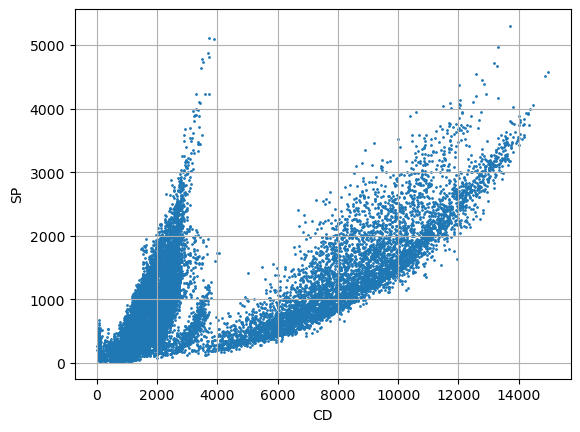

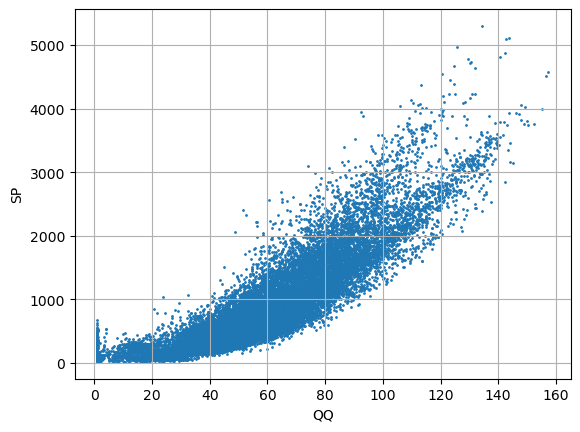

In [188]:
# plot how high the agreement between different methods is
data.plot.scatter(x="CD", y="SP", s=1, grid=True)
data.plot.scatter(x="QQ", y="SP", s=1, grid=True)

In [191]:
data.to_csv("lens_results.csv")

In [189]:
from matplotlib import colors

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

def fmt(s):
    if s > 0:
        return f"{s:.0f}"
    return "-"

# we use the laplacian sharpness / gradient
ddata = data.SP.reset_index(level=["aperture", "focal_length"], drop=True)

# we
d2data = ddata.xs("Crop1", level=-1).xs("CanonEOSR5", level=1).unstack("aperture_float").sort_index(axis=1).sort_values(["title"])
d2data.columns = d2data.columns.map(lambda f: f"{f:.1f}")

d2data.sort_index().interpolate(axis=1, limit=2, limit_area="inside").fillna(0).sort_values(["title", "focal_length_int"]).style.apply(background_gradient,
               cmap='viridis',
               m=0,
               M=4000,
               low=0,
               high=0).format(fmt)